# E-Commerce Orders & Sales Analysis

In [1]:
pip install mysql-connector-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt 
from matplotlib import style    ##for grid styling
%matplotlib inline             
import seaborn as sns

C:\Users\Faizal\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Importing libraries and connecting sql as well python and loading tables within sql and dataframes within python

In [3]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sales'),
    ('products.csv', 'products'),
    ('online_retail_cleaned.csv', 'online_retail_cleaned'),
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items'),
    ('geolocation.csv', 'geolocation') # Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='12345677',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = "C:/Users/Faizal/Downloads/Target datasets"

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [4]:
db = mysql.connector.connect(host = "localhost",
                            username = "root",
                            password = "12345677",
                            database = "ecommerce")

cur = db.cursor()

# List all unique cities where customers are located.

Objective: To identify the diverse geographical locations of customers, which can help in targeted marketing and regional sales strategies.

SQL Query: Used a SELECT DISTINCT statement to fetch unique city names from the customers table.
Tools Used: SQL for querying, Python and Pandas for fetching and displaying the results.

In [5]:
query = """ select distinct customer_city from customers """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017.

Objective: To determine the sales volume for the year 2017, helping in year-over-year growth analysis.
    
SQL Query: Used COUNT and YEAR functions to filter and count orders by the year 2017.
Tools Used: SQL for querying, Python for executing the query and presenting the data.

In [6]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """

cur.execute(query)

data = cur.fetchall()

"total orders placed in 2017 are", data[0][0]

('total orders placed in 2017 are', 315707)

# Find the total sales per category.

Objective: To analyze which product categories are generating the most revenue.
    
SQL Query: Joined products, order_items, and payments tables to sum payment values grouped by product categories.

Tools Used: SQL for complex joins and aggregation, Pandas for further manipulation, and visualization.

In [7]:
query = """ select upper(products.product_category) category, 
round(sum(payments.payment_value),2) sales
from products join order_items 
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Category", "Sales"])
df

,Category,Sales
0,PERFUMERY,3.243127e+07
1,FURNITURE DECORATION,9.153129e+07
2,TELEPHONY,3.116045e+07
3,FASHION BAGS AND ACCESSORIES,1.396213e+07
4,BED TABLE BATH,1.096034e+08
...,...,...
69,CDS MUSIC DVDS,7.676352e+04
70,LA CUISINE,1.864659e+05
71,FASHION CHILDREN'S CLOTHING,5.028288e+04
72,PC GAMER,1.391635e+05


# Calculate the percentage of orders that were paid in installments.

Objective: To understand customer payment preferences and the impact of installment payments on revenue.
    
SQL Query: Used conditional aggregation (CASE statements) to calculate the percentage of installment payments.
    
Tools Used: SQL for querying, Python for calculating and displaying the percentage.

In [8]:
query = """ select ((sum(case when payment_installments >= 1 then 1
else 0 end))/count(*))*100 from payments
"""

cur.execute(query)

data = cur.fetchall()

"the percentage of orders that were paid in installments is", data[0][0]

('the percentage of orders that were paid in installments is',
 Decimal('99.9981'))

# Count the number of customers from each state.

Objective: To identify customer distribution across different states, aiding in region-specific marketing efforts.
    
SQL Query: Used GROUP BY and COUNT to aggregate customer counts by state.
    
Tools Used: SQL for querying, Python, Pandas, Matplotlib for visualization.

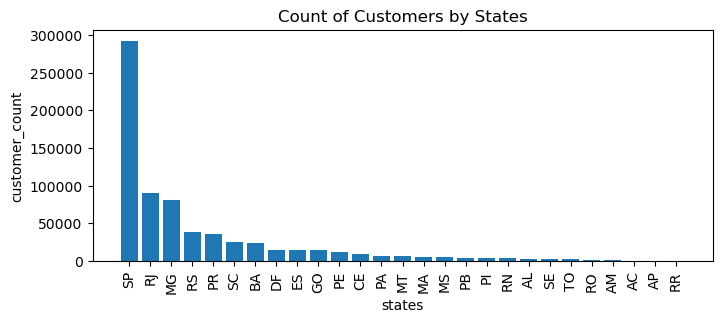

In [9]:
query = """ select customer_state ,count(customer_id)
from customers group by customer_state
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["state", "customer_count" ])
df = df.sort_values(by = "customer_count", ascending= False)

plt.figure(figsize = (8,3))
plt.bar(df["state"], df["customer_count"])
plt.xticks(rotation = 90)
plt.xlabel("states")
plt.ylabel("customer_count")
plt.title("Count of Customers by States")
plt.show()

# Calculate the number of orders per month in 2018.

Objective: To analyze monthly sales trends within 2018, identifying peak and low sales periods.

SQL Query: Used MONTHNAME and YEAR functions to group and count orders by month in 2018.

Tools Used: SQL for querying, Python, Pandas, Seaborn for visualization.

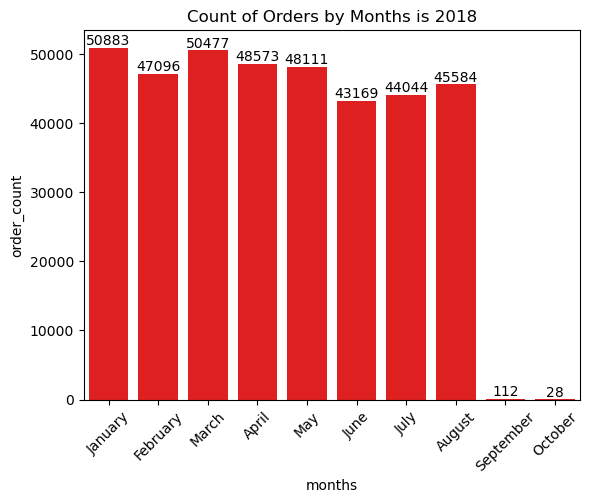

In [10]:
query = """ select monthname(order_purchase_timestamp) months, count(order_id) order_count
from orders where year(order_purchase_timestamp) = 2018
group by months
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["months", "order_count"])
o = ["January", "February","March","April","May","June","July","August","September","October"]

ax = sns.barplot(x = df["months"],y =  df["order_count"], data = df, order = o, color = "red")
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("Count of Orders by Months is 2018")

plt.show()

# Find the average number of products per order, grouped by customer city.

Objective: To determine purchasing behavior in different cities by analyzing the average number of products per order.
    
SQL Query: Used subqueries and joins to count products per order and calculate the average grouped by city.
    
Tools Used: SQL for querying, Python, Pandas for data handling and presentation.

In [11]:
query = """with count_per_order as 
(select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_orders desc
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data,columns = ["customer city", "average products/order"])
df.head(10)

,customer city,average products/order
0,padre carvalho,196.00
1,celso ramos,182.00
2,datas,168.00
3,candido godoi,168.00
4,matias olimpio,140.00
5,cidelandia,112.00
6,curralinho,112.00
7,picarra,112.00
8,morro de sao paulo,112.00
9,teixeira soares,112.00


# Calculate the percentage of total revenue contributed by each product category.

Objective: To understand the revenue distribution across product categories and identify top revenue generators.
    
SQL Query: Joined products, order_items, and payments tables, then calculated revenue percentages for each category.
    
Tools Used: SQL for complex joins and percentage calculations, Python, Pandas for analysis.

In [12]:
query = """select upper(products.product_category) category, 
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales_percentage
from products join order_items 
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category order by sales_percentage desc"""


cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "percentage distribution"])
df.head()

,Category,percentage distribution
0,BED TABLE BATH,171.16
1,HEALTH BEAUTY,165.65
2,COMPUTER ACCESSORIES,158.45
3,FURNITURE DECORATION,142.94
4,WATCHES PRESENT,142.84


# Identify the correlation between product price and the number of times a product has been purchased.

Objective: To explore the relationship between product pricing and purchase frequency.
    
SQL Query: Joined products and order_items tables to calculate average price and count of purchases per product.
    
Tools Used: SQL for querying, Python, Pandas, NumPy for correlation analysis.

In [13]:
cur = db.cursor()
query = """select products.product_category, 
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "order_count","price"])

arr1 = df["order_count"]
arr2 = df["price"]

a = np.corrcoef([arr1,arr2])
print("the correlation is", a[0][-1])

the correlation is -0.10631514167157562


# Calculate the total revenue generated by each seller, and rank them by revenue.

Objective: To identify top-performing sellers based on the total revenue generated.

SQL Query: Joined order_items and payments tables, calculated total revenue per seller, and used DENSE_RANK for ranking.

Tools Used: SQL for querying and ranking, Python, Pandas for visualization.

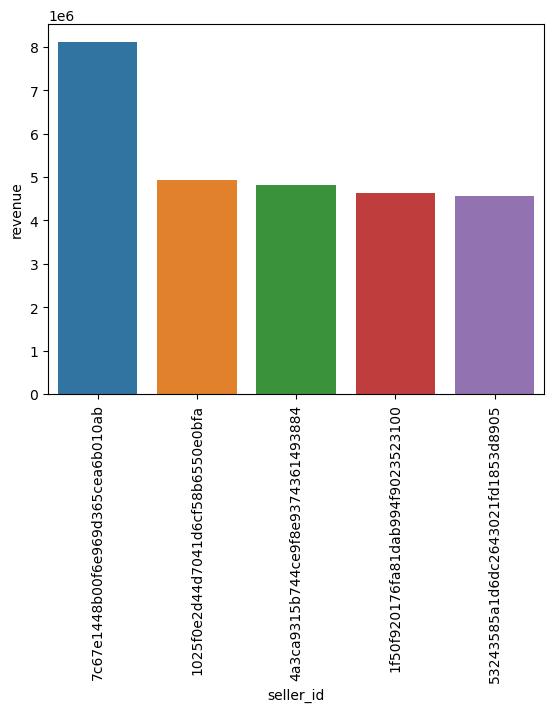

In [14]:
query = """ select *, dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id, sum(payments.payment_value)
revenue from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["seller_id", "revenue", "rank"])
df = df.head()
sns.barplot(x = "seller_id", y = "revenue", data = df)
plt.xticks(rotation = 90)
plt.show()

# Calculate the moving average of order values for each customer over their order history.

Objective: To smooth out fluctuations in order values and identify spending patterns over time.
    
SQL Query: Used window functions to calculate the moving average of order values.
    
Tools Used: SQL for querying, Python, Pandas for handling and presenting the data.

In [15]:
query = """select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp, 
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
4,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
...,...,...,...,...
2908803,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
2908804,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
2908805,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
2908806,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


# Calculate the cumulative sales per month for each year.

Objective: To track the progressive accumulation of sales over each month in different years.

SQL Query: Used window functions to calculate cumulative sales.

Tools Used: SQL for querying, Python, Pandas for analysis.

In [16]:
query = """select years, months , payment, sum(payment)
over(order by years, months) cumulative_sales from 
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years, months) as a
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df

,0,1,2,3
0,2016,9,7062.72,7.062720e+03
1,2016,10,1654533.44,1.661596e+06
2,2016,12,549.36,1.662146e+06
3,2017,1,3877665.12,5.539811e+06
4,2017,2,8173424.27,1.371323e+07
5,2017,3,12596180.79,2.630942e+07
6,2017,4,11698064.83,3.800748e+07
7,2017,5,16601726.96,5.460921e+07
8,2017,6,14315738.65,6.892495e+07
9,2017,7,16586721.75,8.551167e+07


# Calculate the year-over-year growth rate of total sales.

Objective: To measure annual sales growth and assess overall business performance.

SQL Query: Used subqueries and window functions to calculate YoY growth rates.

Tools Used: SQL for querying, Python, Pandas for presentation.

In [17]:
query = """with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years, ((payment - lag(payment, 1) over(order by years))/
lag(payment, 1) over(order by years)) * 100 from a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years", "yoy % growth"])
df

,years,yoy % growth
0,2016,NaN
1,2017,12112.703758
2,2018,20.000924


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

Objective: To evaluate customer loyalty and the effectiveness of retention strategies.
    
SQL Query: Used subqueries and joins to identify repeat purchases within 6 months.
    
Tools Used: SQL for querying, Python, Pandas for analysis.

In [18]:
query = """with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order, interval 6 month)
group by a.customer_id) 

select 100 * (count( distinct a.customer_id)/ count(distinct b.customer_id)) 
from a left join b 
on a.customer_id = b.customer_id ;"""

cur.execute(query)
data = cur.fetchall()

data

[(None,)]

# Identify the top 3 customers who spent the most money in each year.

Objective: To recognize high-value customers and tailor strategies to retain them.

SQL Query: Used subqueries and DENSE_RANK to rank customers by annual spending.

Tools Used: SQL for querying, Python, Pandas, Seaborn for visualization.

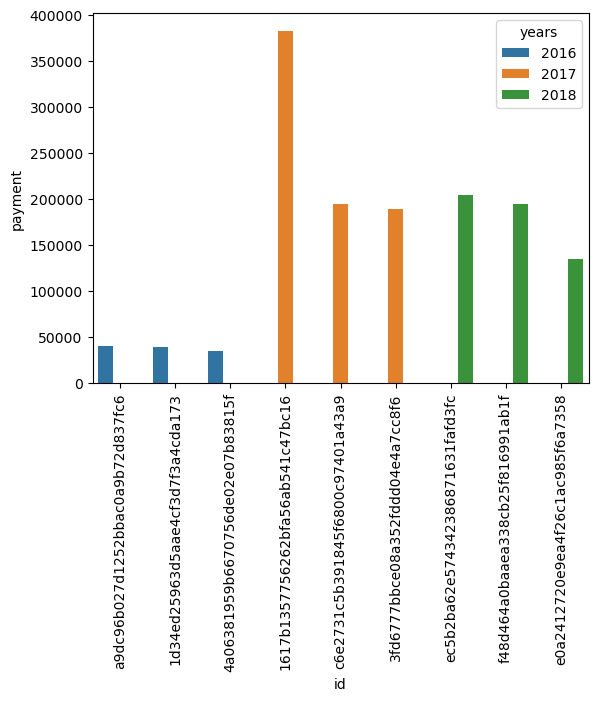

In [19]:
query = """select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 ;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","id","payment","rank"])
sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show()